# Import libraries

In [1]:
import torch
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [2]:
import platform, psutil

print("Sistema operativo:", platform.system(), platform.release())
print("Arquitectura:", platform.machine())

Sistema operativo: Windows 10
Arquitectura: AMD64


In [3]:
# Memoria RAM
mem = psutil.virtual_memory()
print(f"RAM total: {mem.total/1e9:.1f} GB, disponible: {mem.available/1e9:.1f} GB")

RAM total: 68.3 GB, disponible: 48.8 GB


In [4]:
# CPU
cpu_count = psutil.cpu_count(logical=False)
cpu_threads = psutil.cpu_count(logical=True)
print(f"CPU físicos: {cpu_count}, hilos: {cpu_threads}")
print("CPU modelo:", platform.processor())

CPU físicos: 24, hilos: 32
CPU modelo: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel


In [5]:
# Cell 2: información de la GPU (PyTorch)
import torch

if torch.cuda.is_available():
    print("GPU disponible:", torch.cuda.get_device_name(0))
    print("Memoria total GPU:", torch.cuda.get_device_properties(0).total_memory/1e9, "GB")
else:
    print("No se detectó GPU CUDA")

GPU disponible: NVIDIA GeForce RTX 4090 Laptop GPU
Memoria total GPU: 17.170956288 GB


This cell loads preprocessed data from .npy (NumPy binary files), which contain the original data matrices, case labels, and indices. It then checks the shape of the loaded data to ensure it matches the expected dimensions before using it to train a 1D Siamese convolutional network.

In [6]:
# Load .npy files allowing object loading
train_matrices_3d = np.load('data_split/train_matrices.npy', allow_pickle=True)
val_matrices_3d = np.load('data_split/val_matrices.npy', allow_pickle=True)
train_cases = np.load('data_split/train_cases.npy', allow_pickle=True)
val_cases = np.load('data_split/val_cases.npy', allow_pickle=True)
train_indices = np.load('data_split/train_indices.npy', allow_pickle=True)
val_indices = np.load('data_split/val_indices.npy', allow_pickle=True)

# Print the forms of the loaded data to verify
print(train_matrices_3d.shape, val_matrices_3d.shape, train_cases.shape, val_cases.shape)

(3620, 58, 7) (270, 58, 7) (3620,) (270,)


In [7]:
print(train_indices.shape, val_indices.shape)

(3620, 7) (270, 7)


# Convert problem to Binary

This cell defines and applies a function to convert case labels into binary values. The conversion follows this logic:

0 (healthy): Represents dams in a healthy state. All instances of case '0' are converted to the value 0.

1 (damaged): Represents dams with some type of damage. All instances other than '0' (e.g., '1a', '1b', '2a', '2b', '3a', '3b', '4') are converted to the value 1.

This allows the model to distinguish between the two main categories: healthy dams and damaged dams.

In [8]:
# Convert labels to binary
def convert_to_binary(cases):
    return np.where(cases == '0', 0, 1)

# Convert the labels in each dataset
train_cases_binary = convert_to_binary(train_cases)
val_cases_binary = convert_to_binary(val_cases)

In [9]:
# Ensure labels are treated as integers
train_cases_binary = train_cases_binary.astype(int)
val_cases_binary = val_cases_binary.astype(int)

# Pair creation

This is done by ensuring that inverted pairs are not repeated and that positive pairs are not the same data.

This cell defines the create_pairs_with_indices function, which generates positive and negative data pairs to train a Siamese network, while ensuring that the pairs are unique and traceable.

**Positive pairs:** These are formed with two samples with the same label, randomly selected from the same group. It is ensured that the two samples are not the same.

**Negative pairs:** These are formed with two samples with different labels, randomly selected from opposite groups. Duplication of negative pairs is avoided (for example, by swapping sample positions).

**Each pair is associated with:**

The pair's data: Two sequences or time windows (one for each sample in the pair).

The pair's label: 0 for positive pairs (same labels) and 1 for negative pairs (different labels).

The original indices: A list that preserves the indices of the windows that make up each pair, allowing the samples in the original dataset to be traced.

This function organizes data into a format suitable for training a Siamese network, allowing it to learn to differentiate between similar and dissimilar pairs based on the data labels.

In [10]:
def create_pairs_with_indices(data, labels, indices, seed=42):
    """
    Creates positive and negative pairs to train a Siamese network, ensuring reproducibility.
    It also keeps track of the original indices.

    Parameters:
    data (np.ndarray): Data array of shape (n_samples, ...).
    labels (np.ndarray): Array of binary labels of shape (n_samples, ...).
    indices (np.ndarray): Array of original indices of shape (n_samples, window_size).
    seed (int): Seed to ensure reproducibility.

    Returns:
    tuple: Three arrays, one for the data pairs, one for the labels of the pairs, and one for the original indices of the pairs.
    """
    # Set the seed for reproducibility
    np.random.seed(seed)

    pairs = []
    pair_labels = []
    pair_indices = []

    # Dictionary to group data by label #In which indexes do I have 0 and in which 1
    label_to_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}

    # Create positive pairs (same labels)
    for idx in range(len(data)):
        current_label = labels[idx]
        # Select the first positive index other than the current one
        positive_indices = label_to_indices[current_label]
        positive_idx = positive_indices[np.random.choice(len(positive_indices), replace=False)]
        while positive_idx == idx:  # Avoid pairs with yourself
            positive_idx = positive_indices[np.random.choice(len(positive_indices), replace=False)]
        pairs.append([data[idx], data[positive_idx]])
        pair_labels.append(0)  # Label 0 for positive pairs
        pair_indices.append([indices[idx], indices[positive_idx]])

    # Create negative pairs (different labels)
    for idx in range(len(data)):
        current_label = labels[idx]
        negative_label = 1 - current_label  # Change the label (from 0 to 1 or from 1 to 0)
        # Select the first negative index
        negative_indices = label_to_indices[negative_label]
        negative_idx = negative_indices[np.random.choice(len(negative_indices), replace=False)]
        pairs.append([data[idx], data[negative_idx]])
        pair_labels.append(1)  # Label 1 for negative pairs
        pair_indices.append([indices[idx], indices[negative_idx]])

    return np.array(pairs), np.array(pair_labels), np.array(pair_indices)

In [11]:
# Create pairs for the training and validation sets
train_pairs, train_pair_labels, train_pair_indices = create_pairs_with_indices(train_matrices_3d, train_cases_binary, train_indices)
val_pairs, val_pair_labels, val_pair_indices = create_pairs_with_indices(val_matrices_3d, val_cases_binary, val_indices)

In [12]:
# Print the data forms created for verification
print(train_pairs.shape, train_pair_labels.shape)
print(val_pairs.shape, val_pair_labels.shape)

(7240, 2, 58, 7) (7240,)
(540, 2, 58, 7) (540,)


In [13]:
train_pairs.shape, train_pair_labels.shape, train_pair_indices.shape, val_pairs.shape, val_pair_labels.shape, val_pair_indices.shape

((7240, 2, 58, 7), (7240,), (7240, 2, 7), (540, 2, 58, 7), (540,), (540, 2, 7))

**Check the number of positive and negative pairs**

In [14]:
train_positive_pairs = np.sum(train_pair_labels == 0)
train_negative_pairs = np.sum(train_pair_labels == 1)
val_positive_pairs = np.sum(val_pair_labels == 0)
val_negative_pairs = np.sum(val_pair_labels == 1)

print(f"Training set: {train_positive_pairs} positive pairs, {train_negative_pairs} negative pairs")
print(f"Validation set: {val_positive_pairs} positive pairs, {val_negative_pairs} negative pairs")

Training set: 3620 positive pairs, 3620 negative pairs
Validation set: 270 positive pairs, 270 negative pairs


Verify Unique labels

In [15]:
print(np.unique(train_pair_labels))

[0 1]


Review label creation

In [16]:
# Seleccionar un par del conjunto de entrenamiento
pair_idx = 0

# Obtener los índices originales del par
original_indices = train_pair_indices[pair_idx]

# Obtener la etiqueta del par (0 para positivo, 1 para negativo)
pair_label = train_pair_labels[pair_idx]

# Verificar las muestras correspondientes en los datos originales
print(f"Índices originales del par: {original_indices}")
print(f"Etiqueta del par: {pair_label}")

Índices originales del par: [[  0   1   2   3   4   5   6]
 [326 327 328 329 330 331 332]]
Etiqueta del par: 0


# Define Architecture

We place seed

This cell defines a function called set_seed to set a seed in various Python libraries (such as random, numpy, and torch). Setting a seed ensures reproducible results, which is crucial in machine learning and deep learning experiments.

In [17]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the seed
set_seed(42)

This cell defines the SiameseDataset class, a subclass of PyTorch's Dataset. This class allows you to organize and access data in pairs, which is the format required to train a Siamese network. It is designed to handle previously generated data (data pairs and their labels) and structure them into a format suitable for use in a DataLoader.

In [18]:
# Define the SiameseDataset class without including the indexes
class SiameseDataset(Dataset):
    def __init__(self, pairs, pair_labels):
        self.pairs = pairs
        self.pair_labels = pair_labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        x1 = torch.tensor(self.pairs[idx][0].squeeze(), dtype=torch.float32)
        x2 = torch.tensor(self.pairs[idx][1].squeeze(), dtype=torch.float32)
        label = torch.tensor(self.pair_labels[idx], dtype=torch.float32)
        return x1, x2, label

In [19]:
train_dataset = SiameseDataset(train_pairs, train_pair_labels)
val_dataset = SiameseDataset(val_pairs, val_pair_labels)

In [20]:
len(train_dataset)

7240

In [21]:
# Get an example from the training set
train_example = train_dataset[0]
val_example = val_dataset[0]

In [22]:
# Imprimir las formas de los datos
print("Shape of the training set examples:")
print("x1:", train_example[0].shape)
print("x2:", train_example[1].shape)
print("label:", train_example[2].shape)

Shape of the training set examples:
x1: torch.Size([58, 7])
x2: torch.Size([58, 7])
label: torch.Size([])


In [23]:
print("Shape of the validation set examples:")
print("x1:", val_example[0].shape)
print("x2:", val_example[1].shape)
print("label:", val_example[2].shape)

Shape of the validation set examples:
x1: torch.Size([58, 7])
x2: torch.Size([58, 7])
label: torch.Size([])


**Dataloader creation**

This cell configures the PyTorch DataLoaders for the training and validation sets. DataLoaders are responsible for organizing and managing the data in batches, shuffling them, and making them reproducible by setting seeds. This ensures an efficient and controlled flow of data during model training and validation.

In [24]:
# Set the seed for reproducibility
set_seed(42)
batch_size = 256
g = torch.Generator()
g.manual_seed(40)      # semilla reproducible


train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,  # Mix the data for each epoch
    generator=g,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id)  # Reproducible seed for each worker
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id)  
)

In [25]:
# Load a batch and view its contents
dataiter = iter(train_dataloader)
x1_batch, x2_batch, labels_batch = next(dataiter)

In [26]:
print("Shape of x1_batch:", x1_batch.shape)
print("Shape of x2_batch:", x2_batch.shape)
print("Shape of label_batch:", labels_batch.shape)

Shape of x1_batch: torch.Size([256, 58, 7])
Shape of x2_batch: torch.Size([256, 58, 7])
Shape of label_batch: torch.Size([256])


In [27]:
labels_batch

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
        1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0.,
        0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 

In [28]:
# Display the first pair and its label
print("First pair of observations in the batch:")
print("x1:", x1_batch[0])
print("x2:", x2_batch[0])
print("Label:", labels_batch[0])

First pair of observations in the batch:
x1: tensor([[0.8792, 0.9140, 0.9383, 0.9430, 0.9540, 0.9741, 0.9814],
        [0.5733, 0.5583, 0.5855, 0.6051, 0.6121, 0.6019, 0.6181],
        [0.3692, 0.6136, 0.6038, 0.4545, 0.5021, 0.5783, 0.3240],
        [0.4036, 0.2659, 0.3162, 0.2896, 0.3761, 0.4330, 0.3191],
        [0.5591, 0.5940, 0.6138, 0.5588, 0.5740, 0.5934, 0.6044],
        [0.3710, 0.3265, 0.4221, 0.4317, 0.2207, 0.3812, 0.4498],
        [0.5770, 0.5917, 0.5898, 0.5949, 0.6260, 0.6719, 0.6600],
        [0.3343, 0.3210, 0.2919, 0.3125, 0.2499, 0.2010, 0.2375],
        [0.7092, 0.5651, 0.5378, 0.6162, 0.6972, 0.6992, 0.6129],
        [0.5952, 0.6494, 0.5292, 0.7565, 0.5162, 0.6526, 0.5541],
        [0.6757, 0.7211, 0.7395, 0.7423, 0.7774, 0.7579, 0.8371],
        [0.3099, 0.0882, 0.1717, 0.1335, 0.2670, 0.1304, 0.3177],
        [0.6926, 0.7078, 0.7567, 0.7440, 0.7816, 0.7957, 0.8173],
        [0.2893, 0.2553, 0.2015, 0.3000, 0.2655, 0.2136, 0.1743],
        [0.6552, 0.6895, 0.7128

# **Define architecture**

In [29]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(58, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(256 * 1, 256),  # Adjust input size according to Conv1d output size
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64)
        )
        
        self.final_fc = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward_once(self, x):
        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)
        return output

    def forward(self, x1, x2):
        output1 = self.forward_once(x1)
        output2 = self.forward_once(x2)
        abs_diff = torch.abs(output1 - output2)
        output = self.final_fc(abs_diff)
        output = self.sigmoid(output)
        return output

# Training function

In [30]:
import time
import torch

def train_and_validate(model,
                       criterion,
                       optimizer,
                       train_dataloader,
                       val_dataloader,
                       num_epochs=10,
                       patience=10,
                       model_path='best_model.pth'):
    train_losses, val_losses, val_accuracies = [], [], []
    train_times, val_times, epoch_times = [], [], []
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    saved_at_100 = False

    for epoch in range(num_epochs):
        epoch_start = time.perf_counter()

        # Entrenamiento
        train_start = time.perf_counter()
        running_train_loss = 0.0
        model.train()
        for x1, x2, labels in train_dataloader:
            x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).view(-1, 1)
            optimizer.zero_grad()
            output = model(x1, x2)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        train_duration = time.perf_counter() - train_start

        # Validación
        val_start = time.perf_counter()
        running_val_loss = 0.0
        correct, total = 0, 0
        model.eval()
        with torch.no_grad():
            for x1, x2, labels in val_dataloader:
                x1, x2, labels = x1.to(device), x2.to(device), labels.to(device).view(-1, 1)
                output = model(x1, x2)
                running_val_loss += criterion(output, labels).item()
                preds = (output > 0.5).float()
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_duration = time.perf_counter() - val_start

        # Metrics and times
        avg_train_loss = running_train_loss / len(train_dataloader)
        avg_val_loss   = running_val_loss   / len(val_dataloader)
        accuracy       = correct / total
        epoch_duration = time.perf_counter() - epoch_start

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(accuracy)
        train_times.append(train_duration)
        val_times.append(val_duration)
        epoch_times.append(epoch_duration)

        # Logging
        print(f"Epoch [{epoch+1}/{num_epochs}]  "
              f"Train Loss: {avg_train_loss:.4f}  "
              f"Val Loss: {avg_val_loss:.4f}  "
              f"Val Acc: {accuracy:.4f}")
        print(f"    ⏱ Train: {train_duration:.2f}s  "
              f"Val: {val_duration:.2f}s  "
              f"Total: {epoch_duration:.2f}s")

        # Save the best model by loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), model_path)
            print(f"  💾 Mejor modelo guardado por pérdida (loss {avg_val_loss:.4f})")
        else:
            epochs_without_improvement += 1

        # Save the model when it reaches 100% accuracy (only once)
        if accuracy == 1.0 and not saved_at_100:
            torch.save(model.state_dict(), model_path)
            saved_at_100 = True
            print(f"  🏆 Modelo guardado al alcanzar 100% de exactitud en validación")

        # NOTE: We no longer stop training before completing num_epochs

    return {
        'train_losses':    train_losses,
        'val_losses':      val_losses,
        'val_accuracies':  val_accuracies,
        'train_times_s':   train_times,
        'val_times_s':     val_times,
        'epoch_times_s':   epoch_times
    }

Instantiate the model

In [31]:
# Call the seed function before instantiating anything
set_seed(42)

# Define the model, the loss function and the optimizer
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")
model = SiameseNetwork().to(device)  
criterion = nn.BCELoss().to(device)  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {total_params:,}")


Total trainable parameters: 227,969


In [33]:
# Print the initial weights of some layers to verify reproducibility
print("Initial weights of the first Conv1d layer:")
print(model.cnn[0].weight)

print("\nInitial weights of the second Conv1d layer:")
print(model.cnn[3].weight)

print("\nInitial weights of the first fully connected layer:")
print(model.fc[0].weight)

Initial weights of the first Conv1d layer:
Parameter containing:
tensor([[[ 0.0580,  0.0629, -0.0178],
         [ 0.0696, -0.0166,  0.0153],
         [-0.0369,  0.0445,  0.0668],
         ...,
         [-0.0114, -0.0347,  0.0651],
         [ 0.0169, -0.0419, -0.0384],
         [-0.0036,  0.0423, -0.0194]],

        [[-0.0433, -0.0260, -0.0566],
         [ 0.0270,  0.0587, -0.0714],
         [ 0.0176,  0.0392,  0.0137],
         ...,
         [-0.0083, -0.0066, -0.0179],
         [-0.0384, -0.0676, -0.0613],
         [-0.0406,  0.0732, -0.0366]],

        [[-0.0509,  0.0184,  0.0209],
         [ 0.0415,  0.0576,  0.0422],
         [-0.0752,  0.0067,  0.0459],
         ...,
         [-0.0578, -0.0480, -0.0630],
         [ 0.0661, -0.0718,  0.0572],
         [-0.0025, -0.0088,  0.0474]],

        ...,

        [[ 0.0534, -0.0166, -0.0561],
         [-0.0173, -0.0450,  0.0313],
         [ 0.0242, -0.0348,  0.0202],
         ...,
         [-0.0180,  0.0165,  0.0372],
         [-0.0217, -0.0

In [34]:
results = train_and_validate(
    model,
    criterion,
    optimizer,
    train_dataloader,
    val_dataloader,
    num_epochs=30,
    patience=20,
    model_path='best_siamese_model_prueba_final.pth'
)

train_losses   = results['train_losses']
val_losses     = results['val_losses']
val_accuracies = results['val_accuracies']
train_times    = results['train_times_s']
val_times      = results['val_times_s']
epoch_times    = results['epoch_times_s']


Epoch [1/30]  Train Loss: 0.6865  Val Loss: 0.6284  Val Acc: 0.7537
    ⏱ Train: 0.78s  Val: 0.04s  Total: 0.82s
  💾 Mejor modelo guardado por pérdida (loss 0.6284)
Epoch [2/30]  Train Loss: 0.3624  Val Loss: 0.2729  Val Acc: 0.8204
    ⏱ Train: 0.52s  Val: 0.03s  Total: 0.55s
  💾 Mejor modelo guardado por pérdida (loss 0.2729)
Epoch [3/30]  Train Loss: 0.1882  Val Loss: 0.1878  Val Acc: 0.8630
    ⏱ Train: 0.43s  Val: 0.02s  Total: 0.46s
  💾 Mejor modelo guardado por pérdida (loss 0.1878)
Epoch [4/30]  Train Loss: 0.1186  Val Loss: 0.1833  Val Acc: 0.8870
    ⏱ Train: 0.46s  Val: 0.03s  Total: 0.49s
  💾 Mejor modelo guardado por pérdida (loss 0.1833)
Epoch [5/30]  Train Loss: 0.0811  Val Loss: 0.1276  Val Acc: 0.9519
    ⏱ Train: 0.48s  Val: 0.03s  Total: 0.51s
  💾 Mejor modelo guardado por pérdida (loss 0.1276)
Epoch [6/30]  Train Loss: 0.2991  Val Loss: 0.3330  Val Acc: 0.7944
    ⏱ Train: 0.53s  Val: 0.03s  Total: 0.56s
Epoch [7/30]  Train Loss: 0.2423  Val Loss: 0.2659  Val Acc: 0

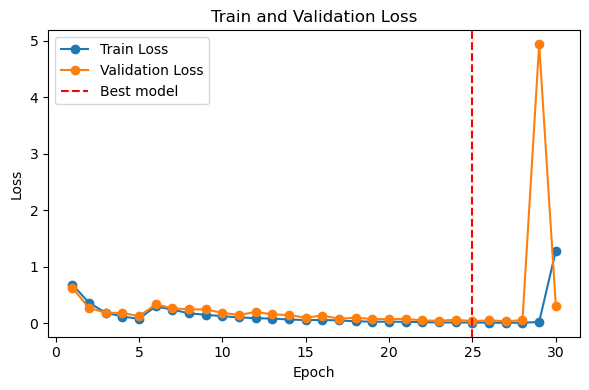

In [35]:
epochs = range(1, len(train_losses) + 1)

# Losses
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')


plt.axvline(25, color='red', linestyle='--', label='Best model')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.tight_layout()

# Guardar la figura en formato EPS
plt.savefig("loss_results.pdf", format="pdf")

# Mostrar la figura
plt.show()

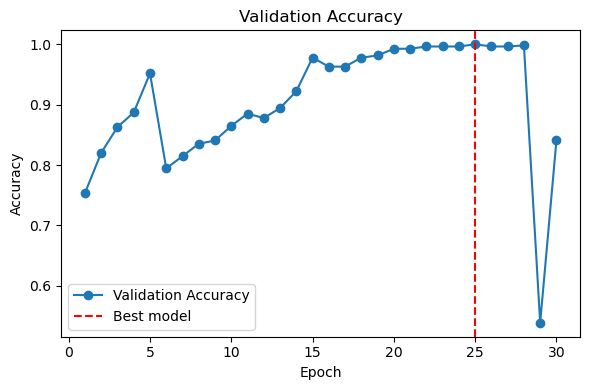

In [36]:
epochs = range(1, len(val_accuracies) + 1)

# Gráfico de accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy')

plt.axvline(25, color='red', linestyle='--', label='Best model')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.tight_layout()

# Guardar la figura en formato EPS
plt.savefig("accuracy_results.pdf", format="pdf")

# Mostrar la figura
plt.show()


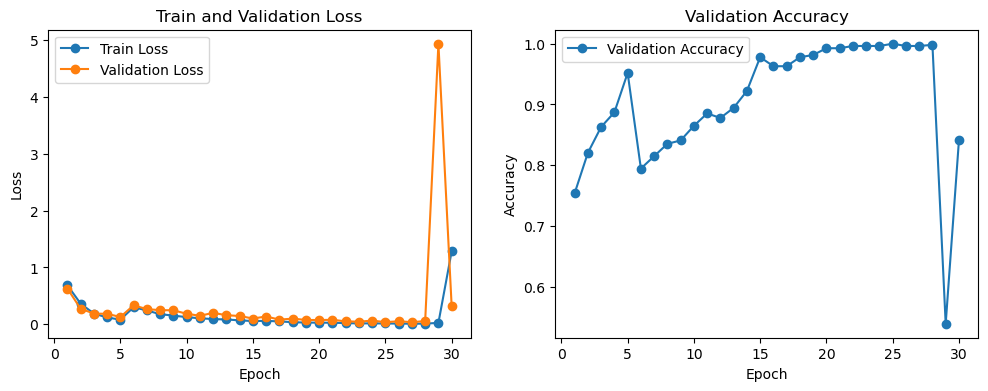

In [37]:
import matplotlib.pyplot as plt


epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.show()